# Project Overview

Brief description of the brain tumor image classification project.

---

# Data Preprocessing

Steps to preprocess the images (e.g., resizing, normalization, augmentation).

### Pasos recomendados

1. **Revisión y curado del dataset**
   - Eliminar duplicados, imágenes corruptas o mal etiquetadas.
   - Verificar coherencia entre nombres de archivos y carpetas.
   - Etiquetar por paciente si es posible (para evitar data leakage).


2. **Redimensionado y transformación de formato**
   - Unificar tamaño de imágenes (por ejemplo, 224x224 px).
   - Convertir a formato RGB si se va a usar un modelo preentrenado.
   - Cambiar a tipo de dato `float32`.

3. **Normalización de los valores de píxeles**
   - Escalar los valores de los píxeles a un rango como `[0, 1]` o `[-1, 1]`.
   - En imágenes médicas, aplicar normalización tipo Z-score si procede.

4. **Balanceo de clases**
   - Verificar si hay desbalance entre "tumor" y "sano".
   - Aplicar estrategias como oversampling, class weighting o pérdida focal.



---

In [1]:
#Resized images
 
from PIL import Image
import os

# Base folder containing 'training' and 'testing'
folder = "/Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive"
new_size = (224, 224)

# Valid image extensions
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")

# Walk through all subdirectories
for subdir, _, files in os.walk(folder):
    for file in files:
        if not file.lower().endswith(valid_extensions):
            continue

        path = os.path.join(subdir, file)
        try:
            with Image.open(path) as img:
                # Convert to RGB to avoid issues with modes like "RGBA", "L", etc.
                img = img.convert("RGB")
                img = img.resize(new_size)
                img.save(path)
                print(f"✅ Resized: {path}")
        except Exception as e:
            print(f"❌ Error processing {path}: {e}")


✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0000.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0001.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0002.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0003.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0004.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0005.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0006.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0007.jpg
✅ Resized: /Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive\Testing\glioma\Te-glTr_0008.jpg
✅ Resized: /Users/lusoz/OneDrive/Escr

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Paso 1: Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Redimensionar a 224x224
    transforms.ToTensor(),              # Convertir a tensor y escalar a [0,1]
    transforms.Normalize(               # Normalizar a [-1,1]
        mean=[0.5, 0.5, 0.5],           
        std=[0.5, 0.5, 0.5]
    )
])

# Paso 2: Cargar los datasets con etiquetas automáticas (por carpeta)
train_dir = "/Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive/training"
test_dir = "/Users/lusoz/OneDrive/Escritorio/brain-tumor-classifier/archive/testing"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Paso 3: Crear los cargadores de datos (data loaders)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar las clases detectadas automáticamente
print("Clases detectadas:", train_dataset.classes)  # ['glioma', 'meningioma', 'pituitary']



Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Exploratory Data Analysis

Visualizations and statistics to understand the dataset.


### Pasos del análisis exploratorio

1. **Resumen general del dataset**
   - Número total de imágenes.
   - Número de imágenes por clase: `tumor` vs `sano`.
   - Número de imágenes por conjunto: entrenamiento, validación y test.
   - Verificar si las clases están balanceadas.

2. **Visualización de ejemplos por clase**
   - Mostrar imágenes representativas de cada clase.
   - Comprobar variabilidad visual entre las clases.
   - Identificar posibles imágenes mal clasificadas, oscuras o ruidosas.

3. **Distribución de tamaños y resoluciones**
   - Analizar si todas las imágenes tienen dimensiones coherentes.
   - Detectar outliers en tamaño o relación de aspecto.

4. **Histograma de intensidades de píxeles**
   - Visualizar histogramas para imágenes individuales o agrupadas por clase.
   - Detectar diferencias de brillo o contraste entre clases.

5. **Comprobación de duplicados o imágenes muy similares**
   - Verificar si hay imágenes repetidas (por nombre o por contenido).
   - Usar técnicas básicas como hashing, distancia estructural, etc.

---

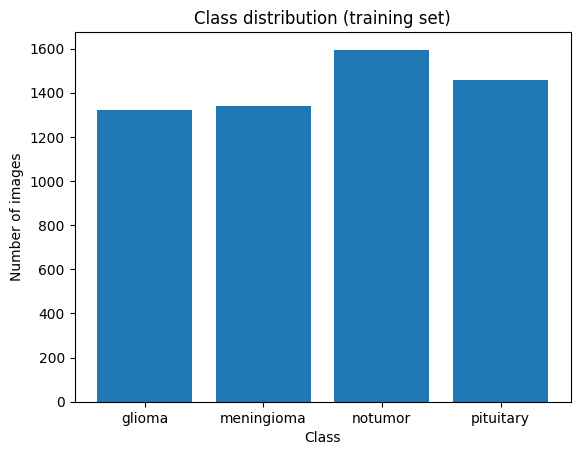

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

labels = [label for _, label in train_dataset]
counter = Counter(labels)
counter

plt.bar(counter.keys(), counter.values(), tick_label=train_dataset.classes)
plt.title("Class distribution (training set)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].


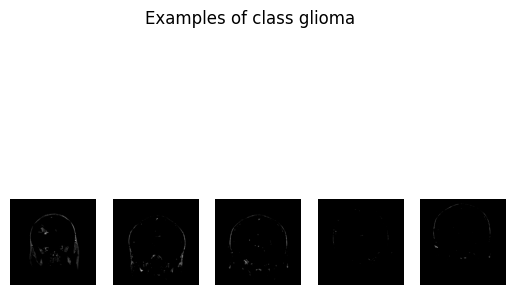

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.73333335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].


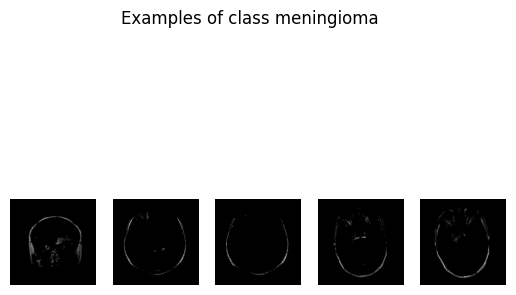

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


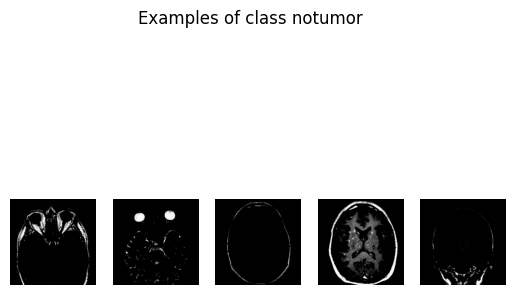

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].


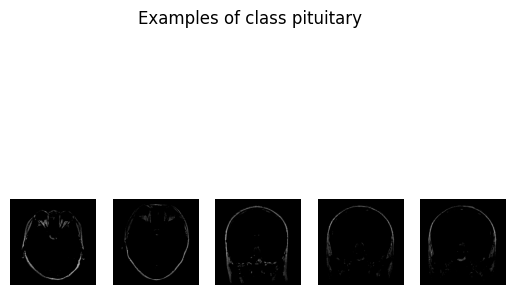

In [12]:
import matplotlib.pyplot as plt

def show_examples(dataset, clas_idx, num_images=5):
    idxs = [i for i,(_, labels) in enumerate(dataset) if labels == clas_idx]
    for i in range(num_images):
        img,_ = dataset[idxs[i]]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.suptitle(f"Examples of class {dataset.classes[clas_idx]}")
    plt.show()


for i in range(len(train_dataset.classes)): 
    show_examples(train_dataset, clas_idx=i)

# Model Building

Define the architecture of the classification model (e.g., CNN).

# Model Training

Train the model using the training dataset.

# Model Evaluation

Evaluate the model performance on the validation/test dataset.

# Predictions

Make predictions on new or unseen images.

# Conclusions and Next Steps

Summarize findings and suggest future improvements.